In [24]:
import os, sys, io
import joblib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange

from keras.layers import (Input, Dense, LSTM, Dropout, TimeDistributed,
                          AveragePooling1D, Flatten, InputLayer, BatchNormalization)
from keras.layers.core import Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras import initializers
import tensorflow as tf

from sklearn import model_selection

sys.path.append('%s/lib' % (os.path.abspath('..')))
from SyntheticLCGenerator import synthetic_light_curve_generator

In [25]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# Main Path
main_path = os.path.abspath('..')

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

In [26]:
def load_synthetic_time_series(data_path=None, n_samples=14000, seq_length=50,
                               time_span=4, n_bands=1, n_signals=1, SNR_min=5,
                               f0_interval='narrow',
                               use_time=True, use_err=True):

    if f0_interval == 'narrow':
        f0_inter = [1/10., 1/1.]
    elif f0_interval == 'wide':
        f0_inter = [1/100., 1/0.01]
    else:
        print('Plese define frequency interval...')
        return

    if os.path.exists(data_path):
        print('Loading from: ', data_path)
        aux = np.load(data_path).item()
        samples = aux['samples']
        labels = np.array(aux['labels'])[:, None]
        periods = aux['periods']
        if n_bands == 1:
            samples = samples.reshape(samples.shape[0], samples.shape[2],
                                      samples.shape[3])
        del aux
        if use_time and not use_err:
            samples = samples[:, :, 0:2]
        if not use_time and not use_err:
            samples = samples[:, :, 1:2]
    return samples, labels, periods


def load_real_time_series(data_path=None, survey='EROS2', n_bands=2,
                          use_time=True, use_err=True):

    if os.path.exists(data_path):
        print('Loading from: ', data_path)
        aux = joblib.load(data_path)
        lcs = aux['lcs']
        meta = aux['meta']
        del aux
        lcs = np.stack([x.values for x in lcs])
        print(lcs.shape)
        if n_bands == 1:
            lcs = lcs[:, :, 0:3]
        if use_time and not use_err:
            lcs = lcs[:, :, 0:2]
        if not use_time and not use_err:
            lcs = lcs[:, :, 1:2]
    return lcs, meta

In [27]:
# You will use the Adam optimizer
def get_optimizer(learning_rate):
    return Adam(lr=learning_rate)


def get_generator(optimizer, G_hidden_units, latent_dim, 
                  out_lc_len, n_feat, dropout=0.1):
    generator = Sequential()

    # LSRM ouputs last state
    # generator.add(LSTM(G_hidden_units, input_shape=(out_lc_len, latent_dim),
    #                    return_sequences=False))
    # generator.add(Dense(out_lc_len*n_feat, activation='tanh'))
    # generator.add(Reshape((out_lc_len, n_feat)))
    
    # using all LSTM outputs (sequence)
    generator.add(LSTM(G_hidden_units, input_shape=(out_lc_len, latent_dim),
                       return_sequences=True))
    generator.add(Dropout(dropout))
    
    # generator.add(LSTM(G_hidden_units,
    #                    return_sequences=True))
    # generator.add(Dropout(dropout))

    generator.add(TimeDistributed(Dense(n_feat, activation='tanh')))
    
    # fully connected layers
    # generatortor.add(Dense())

    generator.compile(loss='mean_squared_error', optimizer=optimizer)
    return generator


def get_discriminator(optimizer, D_hidden_units, lc_len,
                      n_feat, dropout=0.1, D_output=1):
    discriminator = Sequential()

    # LSTM output last state
    discriminator.add(LSTM(D_hidden_units, input_shape=(lc_len, n_feat),
                           return_sequences=False))
    # discriminator.add(Dense(D_hidden_units//2, activation='tanh'))
    discriminator.add(Dropout(dropout))
    discriminator.add(Dense(D_output, activation='softmax'))
    
    
    # using all LSTM states, full sequence
    # discriminator.add(BatchNormalization(axis=-1, input_shape=(lc_len, n_feat)))
    # discriminator.add(LSTM(D_hidden_units, input_shape=(lc_len, n_feat),
    #                        return_sequences=True))
    # discriminator.add(Dropout(dropout))
    
    # discriminator.add(LSTM(D_hidden_units,
    #                        return_sequences=True,
    #                        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    # discriminator.add(Dropout(dropout))
    
    # discriminator.add(TimeDistributed(Dense(D_output, activation='softmax')))
    # discriminator.add(AveragePooling1D(pool_size=lc_len, data_format='channels_last'))
    # discriminator.add(Flatten())

    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer, metrics=['acc'])
    return discriminator

In [5]:
def get_gan_network(discriminator, latent_dim, out_lc_len, generator, optimizer):

    # We initially set trainable to False since we only want
    # to train either the generator or discriminator at a time
    discriminator.trainable = False

    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(out_lc_len, latent_dim))

    # the output of the generator (an image)
    x = generator(gan_input)

    # get the output of the discriminator
    # (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    return gan

#  Extra functions

In [6]:
# Create a wall of generated time series
def plot_generated_time_series(epoch, generated_lc, test_lc=None, examples=8,
                               dim=(2, 4), figsize=(16, 4)):

    fig, ax = plt.subplots(nrows=dim[0], ncols=dim[1], figsize=figsize)
    for i in range(dim[0]):
        for j in range(dim[1]):
            if use_time and use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].errorbar(test_lc[i, :, 0], test_lc[i, :, 1],
                                     yerr=test_lc[i, :, 2], fmt='k.')
                else:
                    ax[i,j].errorbar(generated_lc[(j+i) + j, :, 0], generated_lc[(j+i) + j, :, 1],
                                     yerr=generated_lc[(j+i) + j, :, 2], fmt='b.')
            elif use_time and not use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].plot(test_lc[i, :, 0], test_lc[i, :, 1], 'k.')
                else:
                    ax[i,j].plot(generated_lc[(j+i) + j, :, 0], generated_lc[(j+i) + j, :, 1], 'b.')
            elif not use_time and not use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].plot(test_lc[i, :], 'k.')
                else:
                    ax[i,j].plot(generated_lc[(j+i) + j, :], 'b.')
    plt.tight_layout()
    # plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.show()
    return buf

In [7]:
def write_log_scalar(callback, names, logs, step):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, step)
        callback.writer.flush()
        
def write_log_plot(callback, buf, step):
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    summary = tf.summary.image("Generated_Image", image,
                               max_outputs=1)
    callback.writer.add_summary(tf.keras.backend.eval(summary), step)
    callback.writer.flush()

In [8]:
def normalize(data, norm_time=False, scale_to=[0, 1], n_feat=2):
    normed = np.zeros_like(data)
    for i, lc in enumerate(data):
        normed[i, :, n_feat-1] = (lc[:, n_feat-1] - np.min(lc[:, n_feat-1])) / \
            (np.max(lc[:, n_feat-1]) - np.min(lc[:, n_feat-1]))
        if scale_to != [0, 1]:
            normed[i, :, n_feat-1] = (normed[i, :, n_feat-1] * (scale_to[1] - scale_to[0])) + scale_to[0]
        if norm_time:
            normed[i, :, n_feat-2] = (lc[:, n_feat-2] - np.min(lc[:, n_feat-2])) / \
                (np.max(lc[:, n_feat-2]) - np.min(lc[:, n_feat-2]))
            if scale_to != [0, 1]:
                normed[i, :, n_feat-2] = (normed[i, :, n_feat-2] * (scale_to[1] - scale_to[0])) + scale_to[0]
        else:
            normed[i, :, n_feat-2] = lc[:, n_feat-2]
    return normed


def standarize(data, stand_time=False):
    standar = np.zeros_like(data)
    for i, lc in enumerate(data):
        standar[i, :, 1] = (lc[:, 1] - np.mean(lc[:, 1])) / np.std(lc[:, 1])
        if stand_time:
            standar[i, :, 0] = (lc[:, 0] - np.mean(lc[:, 0])) / np.std(lc[:, 0])
        else:
            standar[i, :, 0] = lc[:, 0]
    return standar


def get_noise(n_samples, n_timesteps=50, latent_dim=5, use_time=True):
    latent = np.random.normal(size=[n_samples, n_timesteps, latent_dim])
    if use_time:
        latent[:, :, 0] = sample_time(n=n_timesteps)
    return latent


def sample_time(n=50, t_range=[0, 4], irregular=True):
    time = np.linspace(t_range[0], t_range[1], num=n*10)
    time = np.random.choice(time, size=n, replace=False)
    return np.sort(time)

# Tsting area

# 3. Settings

In [14]:
# data
n_samples = 28000
n_obs = 50
n_bands = 1
use_time = True
use_err = True
n_feat = 3
if (use_time and not use_err) or (not use_time and use_err):
    n_feat = 2
elif not use_time and not use_err:
    n_feat = 1
data_name = 'SynSine_time%s_err%s' % (str(use_time)[0], str(use_err)[0])
# data_name = 'EROS2_trim215_augmented'

# GAN architecture
model_name = 'LSTM_GAN'
learning_rate = 0.5 # [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
latent_dim = 5
D_hidden_units = 4  # [2, 4, 8, 16, 32, 64, 128]
G_hidden_units = 4
D_output = 1
G_dropout = 0.2
D_dropout = 0.1
batch_size = 28
n_epochs = 200
N_gen_feat = n_feat
save_interval = 5
viz_interval = 10
batch_count = round(7000*.6 / batch_size)
n_examples = 8
gen_lc_len = n_obs

# 2. Retrieve data

In [16]:
data_path = ('%s/data/synthetic/sine_nsamples%i_seqlength%i_nbands%i_nsig%i_timespan%i_SNR%i_f0%s.npy'
             % (main_path, n_samples, n_obs, n_bands, 1, 4, 40, 'narrow'))
samples, labels, periods = load_synthetic_time_series(data_path, use_time=use_time, use_err=use_err)

samples = normalize(samples[:7000], norm_time=True, scale_to=[-1, 1], n_feat=n_feat)
labels = labels[:7000]
periods = periods[:7000]

print('Samples shape: ', samples.shape)

[x_train, x_test, 
 y_train, y_test] = model_selection.train_test_split(samples, labels, 
                                                     train_size=0.6)

Loading from:  /Users/jorgetil/Astro/TL-GANs/data/synthetic/sine_nsamples28000_seqlength50_nbands1_nsig1_timespan4_SNR40_f0narrow.npy
Samples shape:  (7000, 50, 3)


/Users/jorgetil/miniconda3/envs/keras/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
samples[:,:,2]

array([[-0.94507255, -0.48956634, -0.75522786, ..., -0.27313974,
        -0.6523365 , -0.59474058],
       [-0.83164189, -0.23011817, -0.47375412, ..., -0.94711297,
        -0.8877978 , -0.41022852],
       [-0.47524681, -0.50230085, -0.23489792, ..., -0.74311022,
        -0.33752301, -0.52287157],
       ...,
       [-0.38914805, -0.38688117,  0.24508006, ...,  0.47683851,
        -0.8564403 , -1.        ],
       [-1.        ,  0.49936518, -0.488843  , ..., -0.54300996,
        -0.53233034, -0.48740375],
       [-0.3201309 , -0.74912054, -0.58705289, ..., -0.89226871,
        -0.51868404, -0.49331167]])

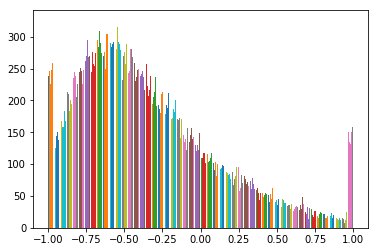

In [18]:
plt.hist(samples[:,:,2], bins=50)
plt.show()

In [11]:
for l_rate in [.00001, .00002, .00005, .0001, .0002, .0005]:
    # Build our GAN netowrk
    print('########## Learning Rate: %f ##########' % (l_rate))
    n_units = 16
    adam = get_optimizer(l_rate)
    generator = get_generator(adam, n_units, latent_dim,
                              n_obs, n_feat, dropout=G_dropout)
    discriminator = get_discriminator(adam, n_units, n_obs,
                                      n_feat, dropout=D_dropout, 
                                      D_output=D_output)
    print('generator')
    print(generator.summary())
    print('discriminator')
    print(discriminator.summary())
    gan = get_gan_network(discriminator, latent_dim, gen_lc_len, generator, adam)
    print('GAN')
    print(gan.summary())

    test_noise = get_noise(n_examples, latent_dim=latent_dim)

    # logger = TensorBoard(log_dir='%s/logs/%s_%s/run_%s/' % 
    #                      (main_path, model_name, data_name,
    #                       datetime.datetime.now().strftime("%y%m%d_%I%M")),
    #                      histogram_freq=0, write_graph=False, write_images=True)
    # logger.set_model(gan)
    loss_G, loss_D = [], []

    for e in range(1, n_epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for n_batch in tnrange(batch_count, desc='# batch'):

            # Get a random set of input noise and real LC's
            real_lc = x_train[n_batch*batch_size: (n_batch+1)*batch_size]
            # real_lc_y = np.random.uniform(.8, 1., size=batch_size)
            real_lc_y = np.ones(batch_size) # * .9

            # Generate fake LC's
            noise = get_noise(batch_size, latent_dim=latent_dim)
            gen_lc = generator.predict(noise)
            # gen_lc_y = np.random.uniform(0., .2, size=batch_size)
            gen_lc_y = np.ones(batch_size) * 0.

            # Train discriminator on real
            # discriminator.trainable = True
            # d_loss_real, d_acc_real = discriminator.train_on_batch(real_lc, real_lc_y)
            # Train discriminator on generated
            # d_loss_gen, d_acc_gen = discriminator.train_on_batch(gen_lc, gen_lc_y)
            # d_loss = d_loss_real + d_loss_gen
            # d_acc = (d_acc_real + d_acc_gen)/2
            
            X = np.concatenate([real_lc, gen_lc])
            y_dis = np.concatenate([real_lc_y, gen_lc_y])
            discriminator.trainable = True
            d_loss, d_acc = discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = get_noise(batch_size, latent_dim=latent_dim)
            # y_gen = np.random.uniform(0.8, 1., size=batch_size)
            y_gen = np.ones(batch_size) # * .9
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)
            
            loss_G.append([(e-1) * batch_count + n_batch ,g_loss])
            loss_D.append([(e-1) * batch_count + n_batch ,d_loss])

            # if n_batch % 10 == 0:
            #     write_log_scalar(logger, ['G_loss', 'D_loss', 'D_acc'],
            #                      [g_loss, d_loss, d_acc],
            #                      (e-1) * batch_count + n_batch)

        print("%d [D loss: %f, acc: %.0f%%] [G loss: %f]" %
              (e, d_loss, d_acc*100, g_loss))
        if d_loss == 0:
            print('Failiure mode...')
            break

        if e == 1 or e % viz_interval == 0:
            lc_test = generator.predict(get_noise(n_examples, latent_dim=latent_dim))
            img_buf = plot_generated_time_series(e, lc_test,
                                                 test_lc=x_test[np.random.randint(0,len(x_test),8)])

            # generator.save('%s/experiments/params/%s_%s_G_%i.hdf5' %
            #               (main_path, model_name, data_name, e))
            # discriminator.save('%s/experiments/params/%s_%s_D_%i.hdf5' %
            #                   (main_path, model_name, data_name, e))

            # write_log_plot(logger, img_buf, (e-1) * batch_count + n_batch)
    
    loss_G = np.array(loss_G)
    loss_D = np.array(loss_D)
    plt.plot(loss_G[:,0], loss_G[:,1], '-b', label='G', linewidth=1)
    plt.plot(loss_D[:,0], loss_D[:,1], '-r', label='D', linewidth=1)
    plt.xlabel('batch iter')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()


########## Learning Rate: 0.000010 ##########
generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 16)            1408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 16)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 2)             34        
Total params: 1,442
Trainable params: 1,442
Non-trainable params: 0
_________________________________________________________________
None
discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1216      

KeyboardInterrupt: 